In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'differential_apa_abundance_c2c12',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, mannwhitneyu, pearsonr
from lapa.result import LapaResult

sns.set_context('poster')

In [3]:
df = pd.read_csv(snakemake.input['stats'])

In [4]:
chrom, pos, strand = zip(*df['polya_site'].str.split(':'))

df['Chromosome'] = chrom
df['Start'] = pos
df['Start'] = df['Start'].astype(int)
df['End'] = df['Start'] + 1
df['Strand'] = strand

In [5]:
result = LapaResult(snakemake.input['long_read'])

In [6]:
df = df.merge(result.read_dataset('myoblast')[['gene_id', 'gene_count']]
              .drop_duplicates()
              .rename(columns={'gene_count': 'myoblast'}), on='gene_id') \
       .merge(result.read_dataset('myotube')[['gene_id', 'gene_count']]
              .drop_duplicates()
              .rename(columns={'gene_count': 'myotube'}), on='gene_id')

df['log(FC)'] = np.log(df['myotube'] / df['myoblast'])

In [7]:
df

,polya_site,odds_ratio,pval,delta_usage,gene_id,pval_adj,gene_name,gene_type,Chromosome,Start,End,Strand,myoblast,myotube,log(FC)
0,chr10:100443912:-,0.000000,2.942635e-08,-0.747475,ENSMUSG00000036676.14,1.763512e-07,Tmtc3,protein_coding,chr10,100443912,100443913,-,80,15,-1.673976
1,chr10:100572273:-,1.924752,5.553080e-02,0.106953,ENSMUSG00000046567.10,9.760826e-02,4930430F08Rik,protein_coding,chr10,100572273,100572274,-,137,96,-0.355633
2,chr10:100572334:-,0.519547,5.553080e-02,-0.106953,ENSMUSG00000046567.10,9.760826e-02,4930430F08Rik,protein_coding,chr10,100572334,100572335,-,137,96,-0.355633
3,chr10:105763195:-,0.827586,6.780249e-01,-0.028737,ENSMUSG00000036009.16,7.694059e-01,Mettl25,protein_coding,chr10,105763195,105763196,-,105,60,-0.559616
4,chr10:105763253:-,1.208333,6.780249e-01,0.028737,ENSMUSG00000036009.16,7.694059e-01,Mettl25,protein_coding,chr10,105763253,105763254,-,105,60,-0.559616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,chrX:98948881:+,0.589008,1.328580e-01,-0.083358,ENSMUSG00000047694.12,2.049981e-01,Yipf6,protein_coding,chrX,98948881,98948882,+,110,114,0.035718
6816,chrX:98948966:+,1.166667,8.132951e-01,0.012125,ENSMUSG00000047694.12,8.888106e-01,Yipf6,protein_coding,chrX,98948966,98948967,+,110,114,0.035718
6817,chrX:98949010:+,1.254920,6.686501e-01,0.023269,ENSMUSG00000047694.12,7.620645e-01,Yipf6,protein_coding,chrX,98949010,98949011,+,110,114,0.035718
6818,chrX:99465767:-,0.440969,1.107138e-07,-0.118844,ENSMUSG00000034403.16,6.138767e-07,Pja1,protein_coding,chrX,99465767,99465768,-,984,387,-0.933201


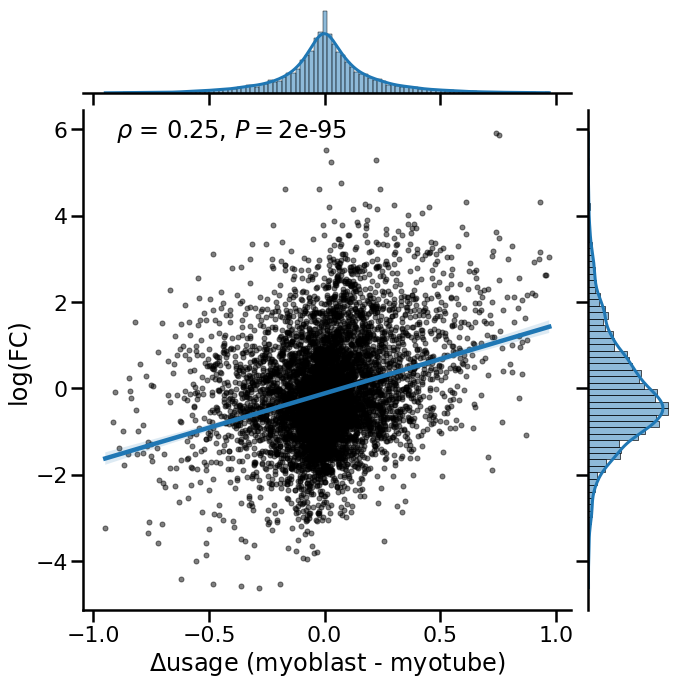

In [8]:
fig = sns.jointplot(data=df, x='delta_usage', y='log(FC)', kind="reg", 
              height=10, scatter_kws={'s': 25, 'alpha': 0.5, 'color': 'black'})
fig.ax_joint.set_xlabel(r'$\Delta$usage (myoblast - myotube)')

coef, pval = spearmanr(df['delta_usage'], df['log(FC)'])

fig.ax_joint.text(-0.9, 5.8, r'$\rho$ = ' + f'{round(coef, 2)}, '+ '$ P = $' + f'{pval:.0e}')
plt.savefig(snakemake.output['scatterplot'], dpi=300, bbox_inches='tight', transparent=True)

In [9]:
df.loc[df[df['Strand'] == '+'].groupby('gene_id')['End'].idxmax(), 'distal'] = True
df.loc[df[df['Strand'] == '-'].groupby('gene_id')['Start'].idxmin(), 'distal'] = True
df['distal'] = ~df['distal'].isna()

In [10]:
df = df[df['distal']]

In [11]:
df['sig'] = (df['delta_usage'].abs() > 0.3) & (df['pval_adj'] < 0.05)

/tmp/ipykernel_57762/671421336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sig'] = (df['delta_usage'].abs() > 0.3) & (df['pval_adj'] < 0.05)


In [12]:
df["3' UTR length"] = np.where(df['delta_usage'] < 0, 'elongation', 'shortening')

/tmp/ipykernel_57762/1416772692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["3' UTR length"] = np.where(df['delta_usage'] < 0, 'elongation', 'shortening')


In [13]:
df.loc[~df['sig'], "3' UTR length"] = 'No Sig.'

In [14]:
sortby = {'shortening':0 , 'elongation': 2, 'No Sig.': 1}

df = df[~df['log(FC)'].isna()].sort_values("3' UTR length", ascending=False, key=lambda x: x.replace(sortby))

No Sig. vs. shortening: Mann-Whitney-Wilcoxon test two-sided, P_val:4.088e-68 U_stat=1.752e+05
elongation vs. No Sig.: Mann-Whitney-Wilcoxon test two-sided, P_val:2.983e-05 U_stat=4.722e+05


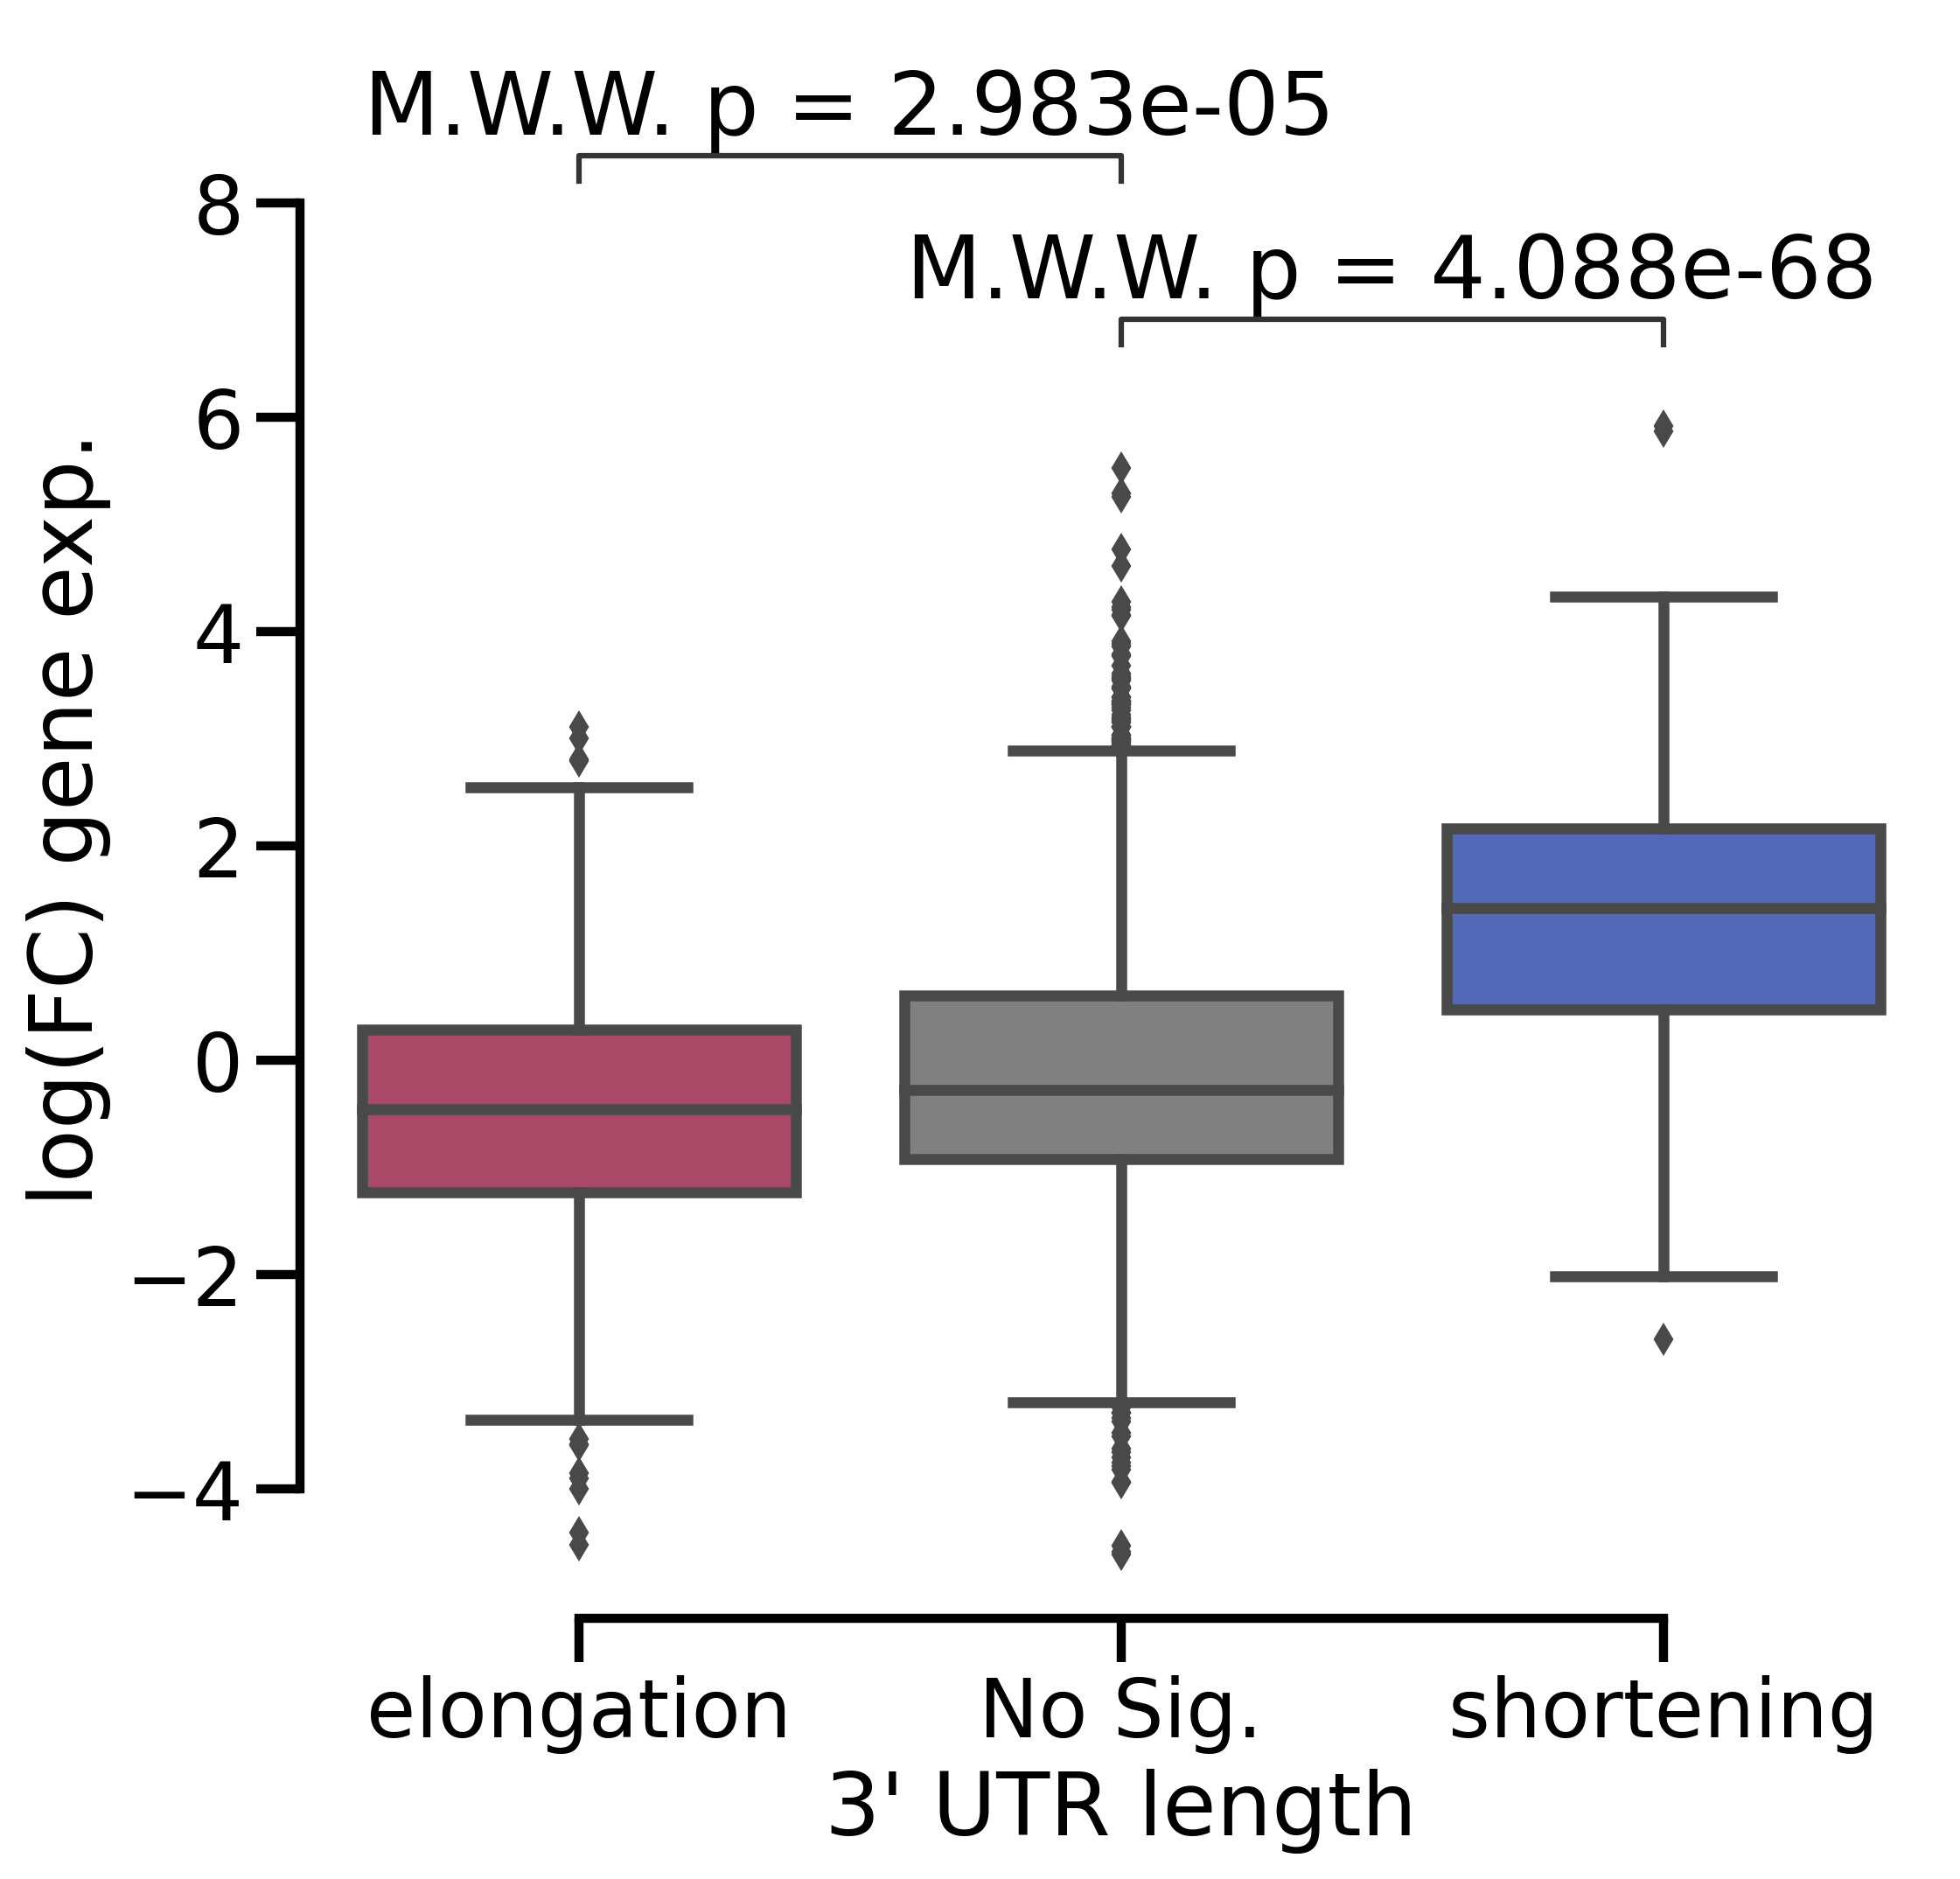

In [15]:
plt.figure(figsize=(8, 8), dpi=300)

ax = sns.boxplot(data=df, x="3' UTR length", y='log(FC)', palette =['#b93961', 'grey', '#4060c8'])

plt.ylabel('log(FC) gene exp.')

from statannotations.Annotator import Annotator

annot = Annotator(ax, plot='boxplot', pairs=[('No Sig.', 'shortening'), ('No Sig.', 'elongation')], 
                  data=df, x="3' UTR length", y='log(FC)')
annot.configure(test='Mann-Whitney', text_format='full').apply_test().annotate()

sns.despine(offset=2, trim=True)

plt.savefig(snakemake.output['boxplot'], dpi=300, bbox_inches='tight', transparent=True)